In [1]:
import commot as ct
import scanpy as sc
import pandas as pd
import numpy as np
from tqdm import tqdm

### Run Commot

In [2]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'cell_type_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

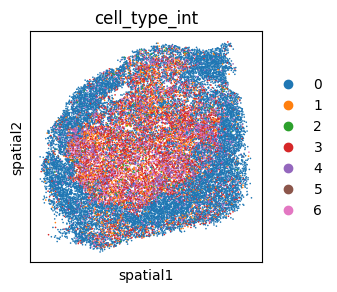

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3, 3]
sc.pl.embedding(adata, 'spatial', color='cell_type_int')

In [8]:
# adata.X = adata.layers['imputed_count']
adata.X = adata.layers['normalized_count']

In [9]:
df_ligrec = ct.pp.ligand_receptor_database(
    database='CellChat', 
    species='mouse', 
    signaling_type=None
)
    
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']  

df_ligrec['name'] = df_ligrec['ligand'] + '-' + df_ligrec['receptor']
len(df_ligrec['name'].unique())

2017

In [10]:
import sys
sys.path.append('../../src')
from spaceoracle.tools.network import expand_paired_interactions

expanded = expand_paired_interactions(df_ligrec)
genes = set(expanded.ligand) | set(expanded.receptor)
genes = list(genes)

expanded

,ligand,receptor,pathway,signaling,name
0,Tgfb1,Tgfbr1,TGFb,Secreted Signaling,Tgfb1-Tgfbr1_Tgfbr2
0,Tgfb1,Tgfbr2,TGFb,Secreted Signaling,Tgfb1-Tgfbr1_Tgfbr2
1,Tgfb2,Tgfbr1,TGFb,Secreted Signaling,Tgfb2-Tgfbr1_Tgfbr2
1,Tgfb2,Tgfbr2,TGFb,Secreted Signaling,Tgfb2-Tgfbr1_Tgfbr2
2,Tgfb3,Tgfbr1,TGFb,Secreted Signaling,Tgfb3-Tgfbr1_Tgfbr2
...,...,...,...,...,...
2016,Itga9,Vcam1,VCAM,Cell-Cell Contact,Itga9_Itgb1-Vcam1
2016,Itgb1,Vcam1,VCAM,Cell-Cell Contact,Itga9_Itgb1-Vcam1
2017,Itga4,Vcam1,VCAM,Cell-Cell Contact,Itga4_Itgb7-Vcam1
2017,Itgb7,Vcam1,VCAM,Cell-Cell Contact,Itga4_Itgb7-Vcam1


In [11]:
expanded = expanded[expanded.ligand.isin(adata.var_names) & expanded.receptor.isin(adata.var_names)]
expanded

,ligand,receptor,pathway,signaling,name
0,Tgfb1,Tgfbr1,TGFb,Secreted Signaling,Tgfb1-Tgfbr1_Tgfbr2
0,Tgfb1,Tgfbr2,TGFb,Secreted Signaling,Tgfb1-Tgfbr1_Tgfbr2
1,Tgfb2,Tgfbr1,TGFb,Secreted Signaling,Tgfb2-Tgfbr1_Tgfbr2
1,Tgfb2,Tgfbr2,TGFb,Secreted Signaling,Tgfb2-Tgfbr1_Tgfbr2
3,Tgfb1,Tgfbr2,TGFb,Secreted Signaling,Tgfb1-Acvr1b_Tgfbr2
...,...,...,...,...,...
2015,Itga4,Vcam1,VCAM,Cell-Cell Contact,Itga4_Itgb1-Vcam1
2015,Itgb1,Vcam1,VCAM,Cell-Cell Contact,Itga4_Itgb1-Vcam1
2016,Itgb1,Vcam1,VCAM,Cell-Cell Contact,Itga9_Itgb1-Vcam1
2017,Itga4,Vcam1,VCAM,Cell-Cell Contact,Itga4_Itgb7-Vcam1


In [12]:
from spaceoracle.tools.utils import scale_adata

scale_adata(adata)

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'cell_type_colors', 'received_ligands', 'received_ligands_tfl', 'cell_type_int_colors'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [13]:
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'cell_type_colors', 'received_ligands', 'received_ligands_tfl', 'cell_type_int_colors'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [14]:
ct.tl.spatial_communication(adata,
    database_name='user_database', 
    # df_ligrec=df_ligrec, 
    df_ligrec=expanded, 
    dis_thr=500, 
    # heteromeric=True
    heteromeric=False
)

In [15]:
adata.write_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')

In [16]:
# lr_info = {k.replace('commot-user_database-', ''): v for k, v in adata.obsp.items() if 'commot-user_database-' in k}
# len(lr_info)

In [17]:
# df_ligrec = df_ligrec[df_ligrec['name'].isin(lr_info.keys())]
# df_ligrec['signaling'].value_counts()

### Get cluster communication scores

In [18]:
expanded['rename'] = expanded['ligand'] + '-' + expanded['receptor']

In [19]:
from tqdm import tqdm
import commot as ct

for name in tqdm(expanded['rename'].unique()):

    ct.tl.cluster_communication(adata, database_name='user_database', pathway_name=name, clustering='cell_type',
        random_seed=12, n_permutations=100)

100%|██████████| 259/259 [05:35<00:00,  1.29s/it]


In [20]:
adata.write_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')

In [21]:
from collections import defaultdict
data_dict = defaultdict(dict)

for name in expanded['rename']:
    data_dict[name]['communication_matrix'] = adata.uns[
        f'commot_cluster-cell_type-user_database-{name}']['communication_matrix']
    data_dict[name]['communication_pvalue'] = adata.uns[
        f'commot_cluster-cell_type-user_database-{name}']['communication_pvalue']

import pickle
with open('/Users/koush/Desktop/training_data/commot_slideseq_mouse_lymphnode_communication.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

In [22]:
# check outputs

import pickle
with open('/Users/koush/Desktop/training_data/commot_slideseq_mouse_lymphnode_communication.pkl', 'rb') as f:
    info = pickle.load(f)

len(info.keys())

259

In [23]:
def get_sig_interactions(value_matrix, p_matrix, pval=0.3):
    p_matrix = np.where(p_matrix < pval, 1, 0)
    return value_matrix * p_matrix

interactions = {}

for lig, rec in tqdm(zip(expanded['ligand'], expanded['receptor']), total=len(expanded)):
    name = lig + '-' + rec

    if name in info.keys():

        value_matrix = info[name]['communication_matrix']
        p_matrix = info[name]['communication_pvalue']

        sig_matrix = get_sig_interactions(value_matrix, p_matrix)
        
        if sig_matrix.sum().sum() > 0:
            interactions[name] = sig_matrix
    
len(interactions)

100%|██████████| 365/365 [00:00<00:00, 6308.65it/s]


257

In [24]:
[i for i in interactions.keys() if 'Il2' in i]

['Il2-Il2ra',
 'Il2-Il2rb',
 'Il2-Il2rg',
 'Il4-Il2rg',
 'Il15-Il2rb',
 'Il15-Il2rg',
 'Il27-Il27ra',
 'Il27-Il6st']

### Get expanded LR masks

In [25]:
# create cell x gene matrix
ct_masks = {ct: adata.obs['cell_type'] == ct for ct in adata.obs['cell_type'].unique()}

df = pd.DataFrame(index=adata.obs_names, columns=genes)
df = df.fillna(0)

for name in tqdm(interactions.keys(), total=len(interactions)):
    lig, rec = name.rsplit('-', 1)
    
    tmp = interactions[name].sum(axis=1)
    for ct, val in zip(interactions[name].index, tmp):
        df.loc[ct_masks[ct], lig] += tmp[ct]
    
    tmp = interactions[name].sum(axis=0)
    for ct, val in zip(interactions[name].columns, tmp):
        df.loc[ct_masks[ct], rec] += tmp[ct]

df.shape

100%|██████████| 257/257 [00:03<00:00, 85.32it/s]


(22227, 993)

In [26]:
print('Number of LR filtered using celltype specificity:')
np.where(df > 0, 1, 0).sum().sum() / (df.shape[0] * df.shape[1])

Number of LR filtered using celltype specificity:


0.1547788222511012

In [27]:
df.loc[:, df.mean() > 0].shape

(22227, 184)

In [28]:
# df.to_parquet('/ix/djishnu/shared/djishnu_kor11/miscellaneous/kidney_commot_LRs.parquet')
df.to_parquet('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode_LRs.parquet')

In [29]:
df.columns[np.where(df.sum() > 0)]

Index(['Cap1', 'Clcf1', 'Ccl20', 'Il2rg', 'Podxl', 'Tnfrsf1b', 'Cxcr3',
       'Siglec1', 'Ctla4', 'Alcam',
       ...
       'Ifngr2', 'Adipoq', 'Ccl12', 'Cdh1', 'Ptprc', 'Sema3a', 'Cd36', 'Itga6',
       'Ptn', 'Col4a2'],
      dtype='object', length=184)

### Cache params in adata

In [30]:
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'cell_type_colors', 'received_ligands', 'received_ligands_tfl', 'cell_type_int_colors', 'commot-user_database-info', 'commot_cluster-cell_type-user_database-Tgfb1-Tgfbr1', 'commot_cluster-cell_type-user_database-Tgfb1-Tgfbr2', 'commot_cluster-cell_type-user_database-Tgfb2-Tgfbr1', 'commot_cluster-cell_type-user_database-Tgfb2-Tgfbr2', 'commot_cluster-cell_type-user_database-Gdf15-Tgfbr2', 'commot_cluster-cell_type-user_database-Wnt7a-Fzd2', 'commot_cluster-cell_type-user_database-Wnt7a-Fzd7', 'commot_cluster-cell_type-user_database-Wnt7a-Fzd8', 'commot_cluster-cell_type-user_database-Wnt7a-Lrp6', 'commot_cluster-cell_type-user_database-Nrg1-Itgav', 'commot_cluster-cell_type-user_database-Nrg1-Itgb3', 'commot_cluster-cell_type-user_database-Igf1-Igf1r', 'commot_cluster-cell_type-user_database-Igf1-Itgav', 'commot_cluster-cell_type-user_database-Ig

In [31]:
from spaceoracle.models.parallel_estimators import *

cell_threshes = pd.read_parquet('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode_LRs.parquet')
adata.uns['cell_thresholds'] = cell_threshes
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'cell_type_colors', 'received_ligands', 'received_ligands_tfl', 'cell_type_int_colors', 'commot-user_database-info', 'commot_cluster-cell_type-user_database-Tgfb1-Tgfbr1', 'commot_cluster-cell_type-user_database-Tgfb1-Tgfbr2', 'commot_cluster-cell_type-user_database-Tgfb2-Tgfbr1', 'commot_cluster-cell_type-user_database-Tgfb2-Tgfbr2', 'commot_cluster-cell_type-user_database-Gdf15-Tgfbr2', 'commot_cluster-cell_type-user_database-Wnt7a-Fzd2', 'commot_cluster-cell_type-user_database-Wnt7a-Fzd7', 'commot_cluster-cell_type-user_database-Wnt7a-Fzd8', 'commot_cluster-cell_type-user_database-Wnt7a-Lrp6', 'commot_cluster-cell_type-user_database-Nrg1-Itgav', 'commot_cluster-cell_type-user_database-Nrg1-Itgb3', 'commot_cluster-cell_type-user_database-Igf1-Igf1r', 'commot_cluster-cell_type-user_database-Igf1-Itgav', 'commot_cluster-cell_type-user_database-Ig

In [32]:
adata = init_received_ligands(
    adata, 
    radius=800, 
    contact_distance=50, 
    cell_threshes=cell_threshes
)
adata

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'cell_type_colors', 'received_ligands', 'received_ligands_tfl', 'cell_type_int_colors', 'commot-user_database-info', 'commot_cluster-cell_type-user_database-Tgfb1-Tgfbr1', 'commot_cluster-cell_type-user_database-Tgfb1-Tgfbr2', 'commot_cluster-cell_type-user_database-Tgfb2-Tgfbr1', 'commot_cluster-cell_type-user_database-Tgfb2-Tgfbr2', 'commot_cluster-cell_type-user_database-Gdf15-Tgfbr2', 'commot_cluster-cell_type-user_database-Wnt7a-Fzd2', 'commot_cluster-cell_type-user_database-Wnt7a-Fzd7', 'commot_cluster-cell_type-user_database-Wnt7a-Fzd8', 'commot_cluster-cell_type-user_database-Wnt7a-Lrp6', 'commot_cluster-cell_type-user_database-Nrg1-Itgav', 'commot_cluster-cell_type-user_database-Nrg1-Itgb3', 'commot_cluster-cell_type-user_database-Igf1-Igf1r', 'commot_cluster-cell_type-user_database-Igf1-Itgav', 'commot_cluster-cell_type-user_database-Ig

In [33]:
# del adata.layers['imputed_count_v0']
# del adata.obsp
keys = list(adata.obsm.keys())
for key in keys:
    if 'commot' in key:
        del adata.obsm[key]

In [34]:
keys = list(adata.uns.keys())
for key in keys:
    if 'commot' in key:
        del adata.uns[key]

In [35]:
keys = list(adata.obsp.keys())
for key in keys:
    if 'commot' in key:
        del adata.obsp[key]

In [39]:
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'cell_type_colors', 'received_ligands', 'received_ligands_tfl', 'cell_type_int_colors'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [38]:
adata.write_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')